## Imports

In [1]:
import os
import sys
import copy
import glob
import tqdm
from torch import nn
import random
import torch
import platform
from typing import Callable, List, Optional, Dict
import numpy as np
import scipy.sparse as sp

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, AutoModel
from unixcoder import UniXcoder

from torch_geometric.data import (
    HeteroData,
    Data,
    InMemoryDataset,
    Batch
    )
from torch_geometric.data.storage import EdgeStorage
import torch_geometric.datasets as datasets
import torch_geometric.transforms as transforms
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, RGATConv
from torch_geometric.nn import global_mean_pool

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, silhouette_score

# To ensure determinism
seed = 1234
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed)

# Check versions
print(torch.__version__)
print(torch.version.cuda)
print(platform.python_version())

2023-05-26 04:22:49.433143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 04:22:50.204334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.0.0+cu117
11.7
3.10.11


## Dataset creation

### Graph file locations

In [2]:
folders = ["/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/PreparedStatement.executeQuery/", 
           "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/Calendar.getTime/",
           "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/URL.openConnection/",
           "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/BufferedReader.readLine/"]

### Method to process raw graph data(in .txt format)

In [3]:
def get_nodes_edges(inTextFile, add_reverse_edges = False):
  # FD = 0, CD = 1
  # to support the hetero data object as suggested by the documentation 
  nodes_dict = {}
  edge_indices_CD = []
  edge_indices_FD = []

  #to support the Data object as used by the Entities dat object as used in RGAT source code
  edge_indices = []
  edge_type = []
  
  # nodes_dict is an index_map
  node_count=0
  with open(inTextFile) as fp:
    
    file_name = inTextFile.split("/")[-1].strip()

    Lines = fp.readlines()
    for line in Lines:

      N = line.split('-->')
      N[0], N[1] = N[0].strip(), N[1].strip()
      
      #t1 = N[0].split('$$')   
      src = N[0].strip()   
      if src not in nodes_dict.keys():
        nodes_dict[src] = node_count
        node_count+=1
        
      #t2 = N[1].split('$$')
      right_idx = N[1].rfind('[')
      dst = N[1][:right_idx].strip()
      if dst not in nodes_dict.keys():
        nodes_dict[dst] = node_count
        node_count+=1

      x = N[1].strip()[right_idx + 1 : -1].strip()
      if(x == 'FD'):
        y=0
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_FD.append([nodes_dict[src], nodes_dict[dst]])
      else: 
        y=1
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_CD.append([nodes_dict[src], nodes_dict[dst]])
     
  return nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type, file_name

In [4]:
file = "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/BufferedReader.readLine/0_sample-1_BufferedReader.readLine_graph_dump.txt"

get_nodes_edges(file, add_reverse_edges = True)

({'Line_2 $$ public void readJournalLines()': 0,
  'Line_3 $$ BufferedReader reader = new BufferedReader(new FileReader(journalFile))': 1,
  'Line_4 $$ while ((line = reader.readLine()) != null)': 2,
  'Line_5 $$ result.add(line)': 3},
 [[1, 2]],
 [[0, 1], [0, 2], [2, 3]],
 [[0, 1], [1, 0], [0, 2], [2, 0], [1, 2], [2, 1], [2, 3], [3, 2]],
 [1, 1, 1, 1, 0, 0, 1, 1],
 '0_sample-1_BufferedReader.readLine_graph_dump.txt')

### Method to get CodeBERT embedding for nodes

In [5]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")
#model.to(device)

In [6]:
def get_node_embedding_from_codebert(nodes):
    list_of_embeddings = []
    for code_line in nodes.keys():
        code_line = code_line.split("$$")[1].strip()
        code_tokens = tokenizer.tokenize(code_line)
        tokens = [tokenizer.cls_token]+code_tokens+[tokenizer.eos_token]
        tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
        context_embeddings = codebert_model(torch.tensor(tokens_ids)[None,:])
        cls_token_embedding = context_embeddings.last_hidden_state[0,0,:]
        list_of_embeddings.append(cls_token_embedding)
    return torch.stack(list_of_embeddings)

### Method to get UniXcoder embedding for nodes

In [7]:
unixcoder_model = UniXcoder("microsoft/unixcoder-base")

def get_node_embedding_from_unixcoder(nodes):
    list_of_embeddings = []
    for code_line in nodes.keys():
        code_line = code_line.split("$$")[1].strip()
        tokens_ids = unixcoder_model.tokenize([code_line],max_length=512,mode="<encoder-only>")
        source_ids = torch.tensor(tokens_ids)
        tokens_embeddings, context_embedding = unixcoder_model(source_ids)
        context_embedding = context_embedding.squeeze(0)
        list_of_embeddings.append(context_embedding)
    return torch.stack(list_of_embeddings)

### Method to create data objects for GNN

In [8]:
def create_graph_dataset(folders):
  dataset =[]
  for label, folder in tqdm.tqdm(enumerate(folders)):
    print("\nProcessing: {}\n".format(folder))
    files = glob.glob(os.path.join(folder, '*.txt'))
    print("\nNumber of files: {}\n".format(len(files)))
    count = 0
    for file in files:

      if(count % 5 == 0):
        print("\nAt file: {}\n".format(count))
      nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type, file_name = get_nodes_edges(file, add_reverse_edges = True)
      if(len(nodes_dict) == 0):
        print("No Data: ", file)
        continue
      #print(nodes_dict, edge_indices_CD, edge_indices_FD, edge_type)

      # Node feature matrix with shape [num_nodes, num_node_features]=(N, 768).
      try:
        CodeEmbedding = get_node_embedding_from_unixcoder(nodes_dict)
      except Exception as e :
        print("Error: ", e)
        print(nodes_dict)
        sys.exit()
      #print(CodeEmbedding.shape)

      # FIXING DATA FOTMATS AND SHAPE
      x = torch.tensor(CodeEmbedding)
      # print(x.shape)
  
      # data.y: Target to train against (may have arbitrary shape),
      # graph-level targets of shape [1, *]
      y = torch.tensor([label], dtype=torch.long)
      #print(type(y))

      # edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]
      edge_index_CD = torch.tensor(edge_indices_CD, dtype=torch.long).t().contiguous()
      edge_index_FD = torch.tensor(edge_indices_FD, dtype=torch.long).t().contiguous()
      edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
      edge_type = torch.tensor(edge_type, dtype=torch.long).t().contiguous()
      #print(edge_index_CD, edge_index_FD, edge_index, edge_type)
  
      data = Data(edge_index=edge_index, edge_type=edge_type, x=x)
      data.y = y
      data.num_nodes = len(nodes_dict)
      data.api = file_name
      dataset.append(data)
      count += 1
    
  return dataset

dataset = create_graph_dataset(folders)
print("\nLength of the dataset: ", len(dataset))

0it [00:00, ?it/s]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/PreparedStatement.executeQuery/


Number of files: 400


At file: 0


At file: 5


At file: 10


At file: 15


At file: 20


At file: 25


At file: 30


At file: 35


At file: 40


At file: 45


At file: 50


At file: 55


At file: 60


At file: 65


At file: 70


At file: 75


At file: 80


At file: 85


At file: 90


At file: 95


At file: 100


At file: 105


At file: 110


At file: 115


At file: 120


At file: 125


At file: 130


At file: 135


At file: 140


At file: 145


At file: 150


At file: 155


At file: 160


At file: 165


At file: 170


At file: 175


At file: 180


At file: 185


At file: 190


At file: 195


At file: 200


At file: 205


At file: 210


At file: 215


At file: 220


At file: 225


At file: 230


At file: 235


At file: 240


At file: 245


At file: 250


At file: 255


At file: 260


At file: 265


At file: 270


At file: 275


At file: 280


At file: 285



1it [00:43, 43.80s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/Calendar.getTime/


Number of files: 531


At file: 0


At file: 5


At file: 10


At file: 15


At file: 20


At file: 25


At file: 30


At file: 35


At file: 40


At file: 45


At file: 50


At file: 55


At file: 60


At file: 65


At file: 70


At file: 75


At file: 80


At file: 85


At file: 90


At file: 95


At file: 100


At file: 105


At file: 110


At file: 115


At file: 120


At file: 125


At file: 130


At file: 135


At file: 140


At file: 145


At file: 150


At file: 155


At file: 160


At file: 165


At file: 170


At file: 175


At file: 180


At file: 185


At file: 190


At file: 195


At file: 200


At file: 205


At file: 210


At file: 215


At file: 220


At file: 225


At file: 230


At file: 235


At file: 240


At file: 245


At file: 250


At file: 255


At file: 260


At file: 265


At file: 270


At file: 275


At file: 280


At file: 285


At file: 290


2it [01:17, 38.09s/it]


At file: 530


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/URL.openConnection/


Number of files: 1028


At file: 0


At file: 5


At file: 10


At file: 15


At file: 20


At file: 25


At file: 30


At file: 35


At file: 40


At file: 45


At file: 50


At file: 55


At file: 60


At file: 65


At file: 70


At file: 75


At file: 80


At file: 85


At file: 90


At file: 95


At file: 100


At file: 105


At file: 110


At file: 115


At file: 120


At file: 125


At file: 130


At file: 135


At file: 140


At file: 145


At file: 150


At file: 155


At file: 160


At file: 165


At file: 170


At file: 175


At file: 180


At file: 185


At file: 190


At file: 195


At file: 200


At file: 205


At file: 210


At file: 215


At file: 220


At file: 225


At file: 230


At file: 235


At file: 240


At file: 245


At file: 250


At file: 255


At file: 260


At file: 265


At file: 270


At file: 275


At file: 280


At file: 2

3it [02:59, 67.31s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/after_pruning/BufferedReader.readLine/


Number of files: 548


At file: 0


At file: 5


At file: 10


At file: 15


At file: 20


At file: 25


At file: 30


At file: 35


At file: 40


At file: 45


At file: 50


At file: 55


At file: 60


At file: 65


At file: 70


At file: 75


At file: 80


At file: 85


At file: 90


At file: 95


At file: 100


At file: 105


At file: 110


At file: 115


At file: 120


At file: 125


At file: 130


At file: 135


At file: 140


At file: 145


At file: 150


At file: 155


At file: 160


At file: 165


At file: 170


At file: 175


At file: 180


At file: 185


At file: 190


At file: 195


At file: 200


At file: 205


At file: 210


At file: 215


At file: 220


At file: 225


At file: 230


At file: 235


At file: 240


At file: 245


At file: 250


At file: 255


At file: 260


At file: 265


At file: 270


At file: 275


At file: 280


At file: 285


At fil

4it [03:43, 55.77s/it]


Length of the dataset:  2507


### Save the dataset

In [10]:
for data in dataset:
    torch.save(data, f'/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/graph_data/with_unixcoder/adding_reverse_edge/{data.api}.pt')

### Load data from existing file 

In [11]:
dataset_folder_path = "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Code_kernel_data/graph_data/with_unixcoder/adding_reverse_edge"
graph_data_files = glob.glob(os.path.join(dataset_folder_path, '*.pt'))
dataset = []
for data_file in graph_data_files:
    data = torch.load(data_file)
    dataset.append(data)

print("\nLength of the dataset: ", len(dataset))


Length of the dataset:  2507


### Filter the datapoints if needed

In [13]:
print("\nLength of the dataset: ", len(dataset))
filtered_dataset = []
for data in dataset:
    if data.num_nodes >=3 :
        filtered_dataset.append(data)
        
print("\nLength of the filtered dataset: ", len(filtered_dataset))


Length of the dataset:  2507

Length of the filtered dataset:  1993


### Graph Statistics & Visualization

In [14]:
print("\nLength of the dataset: ", len(filtered_dataset))

data = filtered_dataset[501]
print(data, "\n")
print('=============================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.edge_index)
print(data.edge_type)
#print(data.x.dtype, data.edge_index.dtype, data.edge_type.dtype, data.y.dtype)


Length of the dataset:  1993
Data(x=[3, 768], edge_index=[2, 6], edge_type=[6], y=[1], num_nodes=3, api='162_sample-0_Calendar.getTime_graph_dump.txt') 

Number of nodes: 3
Number of edges: 6
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([[0, 1, 0, 2, 1, 2],
        [1, 0, 2, 0, 2, 1]])
tensor([1, 1, 1, 1, 0, 0])


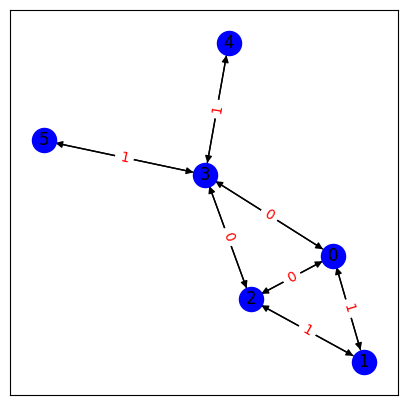

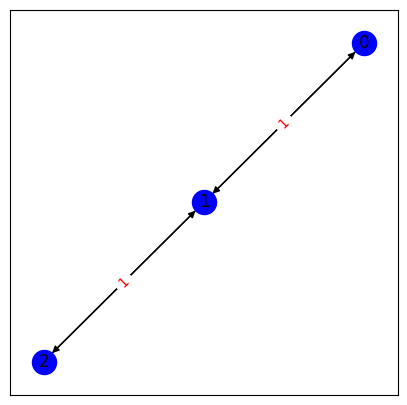

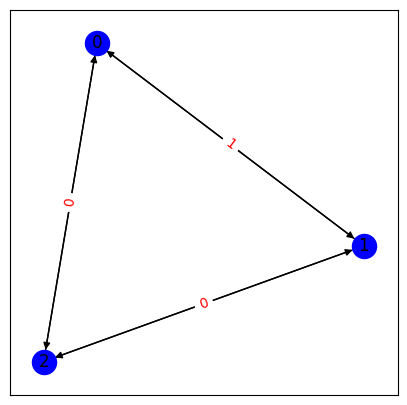

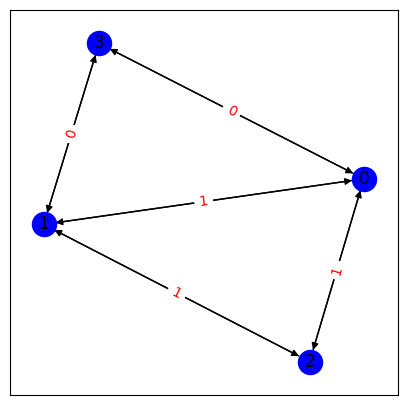

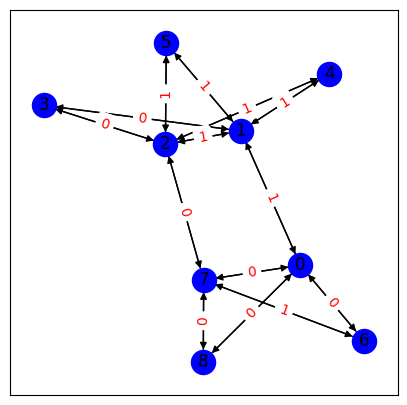

In [15]:
def visualize_graph(data, color):
    G = to_networkx(data, to_undirected=False)
    edge_labels = {}
    for i in range(len(G.edges)):
        edge = list(G.edges)[i]
        edge_labels[edge[0], edge[1]] = int(data.edge_type[i])
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42), edge_labels=edge_labels, font_color='red')
    plt.show()

for G in filtered_dataset[30:35]:
    visualize_graph(G, color="blue")

### Create train and test splits

In [16]:
Label_counter = {"PreparedStatement.executeQuery" : 0, "Calendar.getTime": 0, "URL.openConnection": 0, "BufferedReader.readLine": 0}
for data in filtered_dataset:
    for label in Label_counter:
        if label in data.api:
            Label_counter[label] += 1
            break
print("API labels: ", Label_counter)

API labels:  {'PreparedStatement.executeQuery': 337, 'Calendar.getTime': 332, 'URL.openConnection': 835, 'BufferedReader.readLine': 489}


In [17]:
shuffled_dataset = random.sample(filtered_dataset, len(filtered_dataset))

train_dataset = shuffled_dataset[:int(len(filtered_dataset) * 0.95)]
test_dataset = shuffled_dataset[int(len(filtered_dataset) * 0.95):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1893
Number of test graphs: 100


### Create the dataloaders

In [18]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

## Model

### Define the GCN model

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features = 768, num_classes = 4):
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        graph_embedding = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(graph_embedding, p=0.5, training=self.training)
        x = self.lin(x)
        return x, graph_embedding

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(768, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)


### Define the GAT model

In [5]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features = 768, num_classes = 4):
        super(GAT, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        graph_embedding = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(graph_embedding, p=0.5, training=self.training)
        x = self.lin(x)
        return x, graph_embedding

model = GAT(hidden_channels=64)
print(model)

GAT(
  (conv1): GATConv(768, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)


### Define RGAT model

In [7]:
class RGAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features = 768, num_classes = 4, num_relations = 2):
        super(RGAT, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = RGATConv(num_node_features, hidden_channels, num_relations)
        self.conv2 = RGATConv(hidden_channels, hidden_channels, num_relations)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, edge_type, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_type)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_type)

        # 2. Readout layer
        graph_embedding = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(graph_embedding, p=0.5, training=self.training)
        x = self.lin(x)
        return x, graph_embedding

model = RGAT(hidden_channels=64)
print(model)

RGAT(
  (conv1): RGATConv(768, 64, heads=1)
  (conv2): RGATConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)


### Visualizing the embeddings

In [20]:
def visualize_embeddings(h, color):
    z = umap.UMAP(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

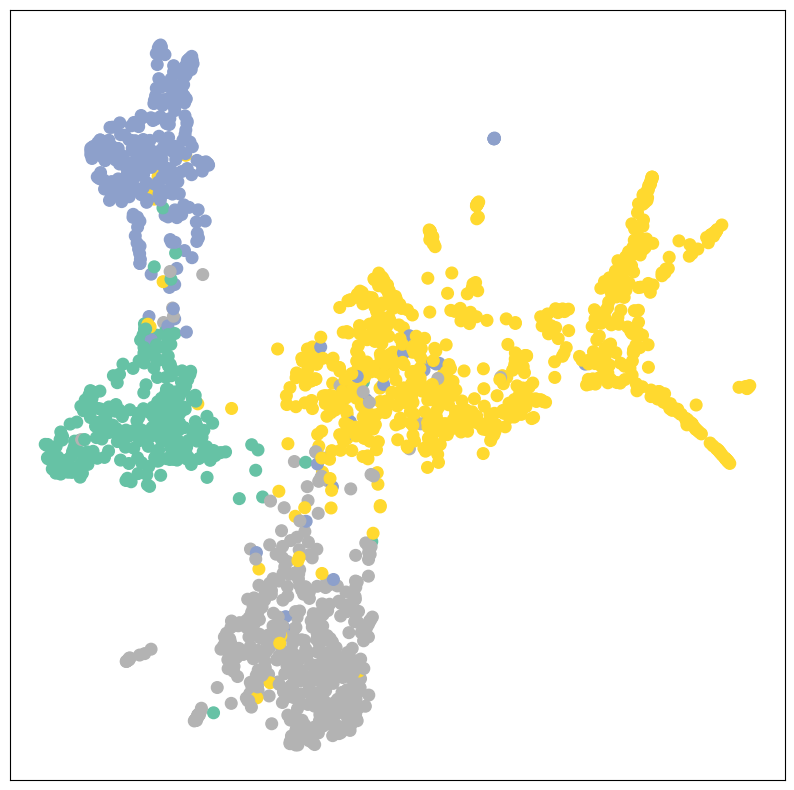

In [22]:
model = GAT(hidden_channels=64)

model.eval()
dataloader = DataLoader(shuffled_dataset, len(shuffled_dataset), shuffle=False)
for data in dataloader:
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)

### Training & Testing

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = "13,14"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.device_count(), torch.cuda.current_device())

cuda 2 0


In [26]:
model = GAT(hidden_channels=64)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
         data.to(device)
         out, _ = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         #print("Out = {} and Label = {}".format(out, data.y))
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         total_loss += float(loss)
    print("Loss: ", total_loss)

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data.to(device)
         out, _ = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(0, 5):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Loss:  29.990086572709597
Epoch: 000, Train Acc: 0.9947, Test Acc: 0.9900
Loss:  18.374535630412787
Epoch: 001, Train Acc: 0.9942, Test Acc: 1.0000
Loss:  20.324075566133494
Epoch: 002, Train Acc: 0.9815, Test Acc: 0.9900
Loss:  55.0111404809565
Epoch: 003, Train Acc: 0.9873, Test Acc: 0.9800
Loss:  41.27802840398935
Epoch: 004, Train Acc: 0.9937, Test Acc: 0.9900


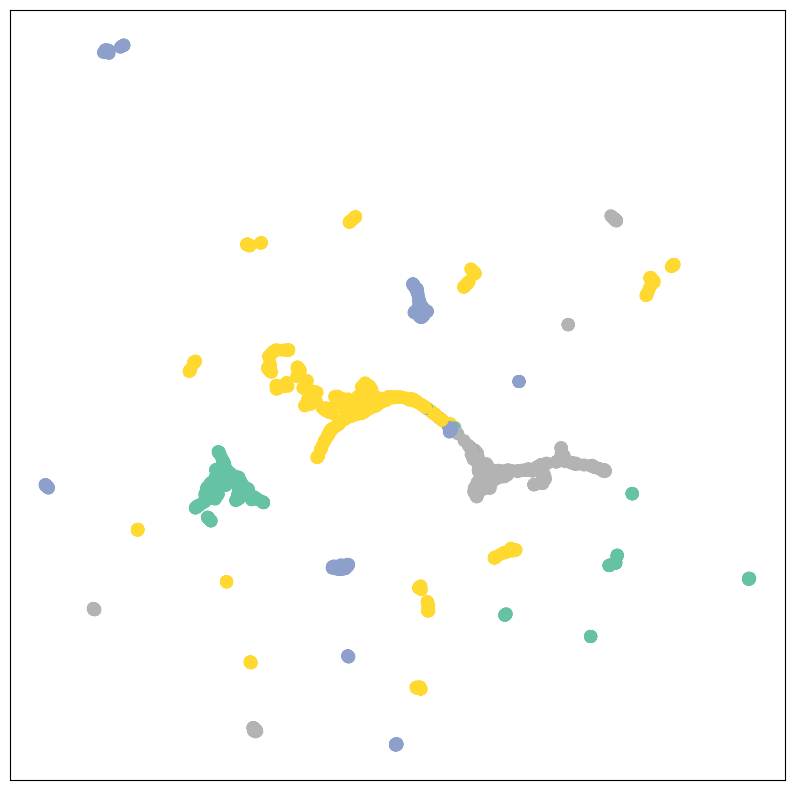

In [28]:
model.eval()
model.to(torch.device("cpu"))
for data in DataLoader(shuffled_dataset, len(shuffled_dataset), shuffle=False):
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)

### Save Model

In [29]:
PATH = "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Saved_models/Graph_classification/GAT/model_with_reverse_edge_unixcoder_1.pt"
torch.save(model.state_dict(), PATH)

### Load Model

In [6]:
PATH = "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/Saved_models/Graph_classification/GAT/model_with_reverse_edge_1.pt"
model = GAT(hidden_channels=64)
model.load_state_dict(torch.load(PATH))
model.eval()

GAT(
  (conv1): GATConv(768, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)

## Cluster the embeddings

### Collect embeddings for a specific class or API

In [15]:
CLASS_LABEL = 2

model.eval()
train_api_embeddings, train_api_datapoints = [], []
test_api_embeddings, test_api_datapoints = [], []

for data in DataLoader(test_dataset, len(test_dataset), shuffle=False):
    _, graph_embedding = model(data.x, data.edge_index, data.edge_type, data.batch)
    for i in range(len(test_dataset)):
        if(int(data[i].y) == CLASS_LABEL):
            test_api_datapoints.append(data[i])
            test_api_embeddings.append(graph_embedding[i].detach().cpu().numpy())
print(len(test_api_embeddings), len(test_api_datapoints))

for data in DataLoader(train_dataset, len(train_dataset), shuffle=False):
    _, graph_embedding = model(data.x, data.edge_index, data.edge_type, data.batch)
    for i in range(len(train_dataset)):
        if(int(data[i].y) == CLASS_LABEL):
            train_api_datapoints.append(data[i])
            train_api_embeddings.append(graph_embedding[i].detach().cpu().numpy())
print(len(train_api_embeddings), len(train_api_datapoints))

total_api_embeddings, total_api_datapoints = train_api_embeddings + test_api_embeddings, train_api_datapoints + test_api_datapoints
print(len(total_api_embeddings), len(total_api_datapoints))

51 51
784 784
835 835


### K-Means

#### Get optimal clusters number

In [ ]:
def elbow_for_kmeans(embeddings):

    inertias, no_of_clusters = [], list(range(1, len(embeddings)))

    for i in no_of_clusters:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)

    plt.plot(no_of_clusters, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()
    
elbow_for_kmeans(train_api_embeddings)

#### Do clustering

In [ ]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(train_api_embeddings)
test_api_clusters_kmeans = kmeans.predict(test_api_embeddings)
print(test_api_clusters_kmeans)

[9 9 8 5 0 0 2 4 4 5 5 7 9 7 2 2 8 0 8 8 1 0 3 6 0 1 0 7 5 1 1 1 9 0 8 5 9
 8 0 8 2 0]


#### Visualize using t-SNE 

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objs as go
import chart_studio.plotly as py
import pandas as pd

def visualize_clusters_using_tsne(vectors, clusters):

    tsne_output_2d = TSNE(n_components = 2).fit_transform(vectors)
    tsne_dataframe_2d = pd.DataFrame(tsne_output_2d)
    tsne_dataframe_2d['cluster'] = clusters
    tsne_dataframe_2d.columns = ['x1','x2','cluster']

    tsne_output_3d = TSNE(n_components = 3).fit_transform(vectors)
    tsne_dataframe_3d = pd.DataFrame(tsne_output_3d)
    tsne_dataframe_3d['cluster'] = clusters
    tsne_dataframe_3d.columns = ['x1','x2', 'x3', 'cluster']

    fig = px.scatter(
        tsne_dataframe_2d[["x1", "x2"]], x="x1", y="x2",
        color=tsne_dataframe_2d["cluster"], labels={'color': 'clusters'}
    )
    fig.show()

    fig = px.scatter_3d(
        tsne_dataframe_3d[["x1", "x2", "x3"]], x="x1", y="x2", z="x3",
        color=tsne_dataframe_3d["cluster"], labels={'color': 'clusters'}
    )
    fig.update_traces(marker_size = 8)
    fig.show()

visualize_clusters_using_tsne(train_api_embeddings, kmeans.predict(train_api_embeddings))

KeyboardInterrupt: 

#### Visualize using UMAP

In [ ]:
from umap import UMAP
import plotly.express as px

def visualize_clusters_using_umap(vectors, clusters):

    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    umap_output_2d = umap_2d.fit_transform(vectors)
    umap_dataframe_2d = pd.DataFrame(umap_output_2d)
    umap_dataframe_2d['cluster'] = clusters
    umap_dataframe_2d.columns = ['x1','x2', 'cluster']

    umap_3d = UMAP(n_components=3, init='random', random_state=0)
    umap_output_3d = umap_3d.fit_transform(vectors)
    umap_dataframe_3d = pd.DataFrame(umap_output_3d)
    umap_dataframe_3d['cluster'] = clusters
    umap_dataframe_3d.columns = ['x1','x2', 'x3', 'cluster']

    fig_2d = px.scatter(
        umap_dataframe_2d[["x1", "x2"]], x="x1", y="x2",
        color=umap_dataframe_2d["cluster"], labels={'color': 'clusters'}
    )
    fig_3d = px.scatter_3d(
        umap_dataframe_3d[["x1", "x2", "x3"]], x="x1", y="x2", z="x3",
        color=umap_dataframe_3d["cluster"], labels={'color': 'clusters'}
    )
    fig_3d.update_traces(marker_size=5)

    fig_2d.show()
    fig_3d.show()
    
visualize_clusters_using_umap(train_api_embeddings, kmeans.predict(train_api_embeddings))

### BIRCH Clustering

In [ ]:
from sklearn.cluster import Birch

model.eval()
filtered_dataset_api_embeddings, filtered_dataset_api_datapoints = [], []

for data in DataLoader(filtered_dataset, len(filtered_dataset), shuffle=False):
    _, graph_embedding = model(data.x, data.edge_index, data.batch)
    for i in range(len(filtered_dataset)):
        filtered_dataset_api_datapoints.append(data[i])
        filtered_dataset_api_embeddings.append(graph_embedding[i].detach().cpu().numpy())
print(len(filtered_dataset_api_embeddings), len(filtered_dataset_api_datapoints))

birch_model = Birch(n_clusters = None)
filtered_dataset_clusters_birch = birch_model.fit_predict(train_api_embeddings)
print(len(set(filtered_dataset_clusters_birch)))

1947 1947
58


#### Do clustering

In [ ]:
from sklearn.cluster import Birch

birch_model = Birch(n_clusters = None)
train_api_clusters_birch = birch_model.fit_predict(train_api_embeddings)
test_api_clusters_birch = birch_model.predict(test_api_embeddings)


In [ ]:
d = {}
for i in train_api_clusters_birch:
    if i in d:
        d[i] += 1
    else:
        d[i] = 1
print(d)

{0: 19, 1: 14, 2: 25, 3: 4, 62: 41, 4: 1, 59: 6, 76: 5, 43: 10, 64: 29, 65: 6, 101: 4, 6: 11, 7: 25, 67: 2, 78: 7, 34: 3, 18: 5, 85: 11, 68: 11, 92: 10, 9: 18, 69: 2, 23: 6, 73: 35, 70: 18, 10: 4, 58: 5, 11: 14, 71: 33, 12: 5, 13: 2, 72: 2, 8: 19, 66: 23, 44: 8, 74: 7, 91: 5, 14: 4, 63: 20, 45: 1, 77: 6, 46: 3, 47: 3, 79: 4, 5: 8, 80: 15, 36: 8, 81: 10, 30: 5, 28: 7, 17: 22, 82: 6, 32: 11, 94: 13, 75: 11, 15: 8, 95: 3, 83: 1, 84: 4, 16: 11, 37: 10, 104: 4, 48: 1, 31: 4, 20: 2, 86: 1, 87: 2, 88: 4, 89: 5, 51: 3, 90: 2, 19: 3, 22: 4, 49: 3, 50: 6, 21: 6, 24: 6, 52: 2, 25: 8, 26: 5, 93: 3, 27: 3, 53: 1, 54: 1, 29: 1, 41: 3, 96: 1, 55: 1, 33: 5, 97: 3, 98: 1, 35: 1, 99: 1, 100: 1, 56: 1, 57: 2, 38: 1, 39: 2, 40: 1, 102: 4, 103: 1, 105: 1, 106: 1, 107: 1, 42: 1, 60: 1, 61: 1, 108: 1}


#### Visualize using t-SNE

In [ ]:
visualize_clusters_using_tsne(train_api_embeddings, train_api_clusters_birch)

#### Visualize using UMAP

In [ ]:
visualize_clusters_using_umap(train_api_embeddings, train_api_clusters_birch)

### DBSCAN Clustering

#### Do clustering

In [ ]:
from sklearn.cluster import DBSCAN

train_api_clusters_dbscan = DBSCAN(eps=10, min_samples=4).fit_predict(train_api_embeddings)
print("Clusters: {}".format(train_api_clusters_dbscan))

Clusters: [0 0 0 ... 0 0 0]
{0}


#### Visualize using TSNE

In [ ]:
visualize_clusters_using_tsne(train_api_embeddings, train_api_clusters_dbscan)

#### Visualize using UMAP

In [ ]:
visualize_clusters_using_umap(train_api_embeddings, train_api_clusters_dbscan)

## Compare with Code-Kernel

### Get Code-Kernel cluster details for a particular API

In [42]:
print("\nAPI name: ", total_api_datapoints[0].api)

code_kernel_clusters = {}
code_kernel_api_cluster_mapping = {}

for data in total_api_datapoints:
    name_parts = data.api.split("_")
    file_name, cluster_no, api_name = name_parts[0].strip(), name_parts[1].strip(), name_parts[2].strip()
    if cluster_no in code_kernel_clusters:
        code_kernel_clusters[cluster_no].append(data.api)
    else:
        code_kernel_clusters[cluster_no] = [data.api]
    code_kernel_api_cluster_mapping[data.api] = cluster_no
        
print("\nTotal data points: ", len(code_kernel_api_cluster_mapping))
print("\nNumber of cluster in Code-Kernel: ", len(code_kernel_clusters))
for cluster_no in code_kernel_clusters:
    print("{} : {}".format(cluster_no, len(code_kernel_clusters[cluster_no])))


API name:  12_sample-2_URL.openConnection_graph_dump.txt

Total data points:  835

Number of cluster in Code-Kernel:  17
sample-2 : 69
sample-0 : 370
sample-4 : 19
sample-1 : 230
sample-13 : 8
sample-11 : 10
sample-8 : 10
sample-3 : 44
sample-7 : 9
sample-6 : 15
sample-15 : 7
sample-12 : 9
sample-10 : 12
sample-5 : 9
sample-9 : 1
sample-14 : 8
sample-16 : 5


### Create cluster-classification ground-truth from Code-Kernel data

In [2]:
def do_classification_from_clustering(data_to_cluster_map):
    classification = {}
    data_points = list(data_to_cluster_map.keys())
    for i in range(len(data_points)):
        j = i+1
        while j < len(data_points):
            classification[tuple([data_points[i], data_points[j]])] = 1 if data_to_cluster_map[data_points[i]] == data_to_cluster_map[data_points[j]] else 0
            j += 1
    return classification

In [44]:
code_kernel_classification = do_classification_from_clustering(code_kernel_api_cluster_mapping)
print("\nTotal code-kernel classifications : ", len(code_kernel_classification))


Total code-kernel classifications :  348195


### Cluster GNN embeddings with same cluster numbers

In [47]:
birch_model = Birch(n_clusters = 17)
total_api_clusters_birch = birch_model.fit_predict(total_api_embeddings)

total_api_cluster_mapping = {}
for data, cluster in zip(total_api_datapoints, total_api_clusters_birch):
    total_api_cluster_mapping[data.api] = cluster
    
print("\nTotal data points: ", len(total_api_cluster_mapping))
total_api_classification = do_classification_from_clustering(total_api_cluster_mapping)
print("\nTotal GNN classifications : ", len(total_api_classification))


Total data points:  835

Total GNN classifications :  348195


### Compare GNN clustering accuracy wrt Code-Kernel

In [49]:
code_kernel_labels, GNN_labels = [], []
for pair in total_api_classification:
    code_kernel_labels.append(code_kernel_classification[pair])
    GNN_labels.append(total_api_classification[pair])
    
print("\nConfusion Matrix: ", confusion_matrix(code_kernel_labels, GNN_labels))
print("\nAccuracy: ", accuracy_score(code_kernel_labels, GNN_labels) * 100)
print("\nF1-Score: ", f1_score(code_kernel_labels, GNN_labels) * 100)
print("\nPrecision: ", precision_score(code_kernel_labels, GNN_labels) * 100)
print("\nRecall: ", recall_score(code_kernel_labels, GNN_labels) * 100)


Confusion Matrix:  [[213252  36424]
 [ 81637  16882]]

Accuracy:  66.09342466146842

F1-Score:  22.238761732257533

Precision:  31.66998086519341

Recall:  17.13578091535643


## Compare with Code-Kernel using manually labelled data

### Create the graph dataset

In [33]:
folder_path = "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning"
pdg_folders_list = glob.glob(folder_path + "/*/")
print("\nNumber of total APIs: {}\n".format(len(pdg_folders_list)))

manual_dataset = create_graph_dataset(pdg_folders_list)
print("\nLength of the manually labelled dataset: ", len(manual_dataset))


Number of total APIs: 11



0it [00:00, ?it/s]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/Servant._poa/


Number of files: 14


At file: 0


At file: 5


At file: 10



1it [03:37, 217.32s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/FileUtils.forceMkdir/


Number of files: 4


At file: 0



2it [04:09, 108.62s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/Driver.connect/


Number of files: 31


At file: 0


At file: 5


At file: 10


At file: 15


At file: 20


At file: 25


At file: 30



3it [08:40, 182.41s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/FileUtils.writeStringToFile/


Number of files: 10


At file: 0


At file: 5



4it [10:44, 159.69s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/IOUtils.toByteArray/


Number of files: 8


At file: 0


At file: 5



5it [12:12, 133.77s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/Properties.loadFromXML/


Number of files: 24


At file: 0


At file: 5


At file: 10


At file: 15


At file: 20



6it [16:26, 174.66s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/PrinterJob.pageDialog/


Number of files: 35


At file: 0


At file: 5


At file: 10


At file: 15


At file: 20


At file: 25


At file: 30



7it [20:55, 205.47s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/FilenameUtils.normalize/


Number of files: 5


At file: 0



8it [21:31, 151.55s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/Graphics2D.fill/


Number of files: 40


At file: 0


At file: 5


At file: 10


At file: 15


At file: 20


At file: 25


At file: 30


At file: 35



9it [27:32, 216.82s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/Window.pack/


Number of files: 9


At file: 0


At file: 5



10it [28:13, 162.66s/it]


Processing: /raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/after_pruning/IOUtils.toString/


Number of files: 17


At file: 0


At file: 5


At file: 10


At file: 15



11it [32:02, 174.75s/it]


Length of the manually labelled dataset:  197


In [34]:
for data in manual_dataset:
    torch.save(data, f'/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/graph_data/with_unixcoder/adding_reverse_edge/{data.api}.pt')

In [35]:
print("\nLength of the manual dataset: ", len(manual_dataset))
filtered_manual_dataset = []
for data in manual_dataset:
    if data.num_nodes >= 3 :
        filtered_manual_dataset.append(data)
        
print("\nLength of the filtered manual dataset: ", len(filtered_manual_dataset))


Length of the manual dataset:  197

Length of the filtered manual dataset:  149


In [36]:
print("\nLength of the dataset: ", len(filtered_manual_dataset))

data = filtered_manual_dataset[0]
print(data, "\n")
print('=============================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.edge_index)
print(data.edge_type)


Length of the dataset:  149
Data(x=[3, 768], edge_index=[2, 6], edge_type=[6], y=[1], num_nodes=3, api='A__poa_086_PortableRemoteObjectDelegateImpl_0_0_4_sample-4_Servant._poa_graph_dump.txt') 

Number of nodes: 3
Number of edges: 6
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([[0, 1, 0, 2, 1, 2],
        [1, 0, 2, 0, 2, 1]])
tensor([1, 1, 1, 1, 0, 0])


### Load existing data

In [3]:
dataset_folder_path = "/raid/tamalm/API-Misuse-Research/PDG-Gen/Repository/CodeKernel_Manual_Data/Processed_data/graph_data/with_codebert/adding_reverse_edge"
graph_data_files = glob.glob(os.path.join(dataset_folder_path, '*.pt'))
manual_dataset = []
for data_file in graph_data_files:
    data = torch.load(data_file)
    manual_dataset.append(data)

print("\nLength of the manual dataset: ", len(manual_dataset))
filtered_manual_dataset = []
for data in manual_dataset:
    if data.num_nodes >= 3 :
        filtered_manual_dataset.append(data)
        
print("\nLength of the filtered manual dataset: ", len(filtered_manual_dataset))


Length of the manual dataset:  197

Length of the filtered manual dataset:  149


### Get the embeddings

In [7]:
model.eval()
manual_data_embeddings = {}

for data in DataLoader(manual_dataset, len(manual_dataset), shuffle=False):
    _, graph_embedding = model(data.x, data.edge_index, data.batch)
    for i in range(len(manual_dataset)):
        manual_data_embeddings[data[i].api] = graph_embedding[i].detach().cpu().numpy()
    
print(len(manual_data_embeddings))

197


### Get cluster labels for Ground-truth, Code-Kernel and GNN

In [8]:
APIs = ["Driver.connect", "FilenameUtils.normalize", "FileUtils.forceMkdir", "FileUtils.writeStringToFile", "Graphics2D.fill", 
        "IOUtils.toByteArray", "IOUtils.toString", "PrinterJob.pageDialog", "Properties.loadFromXML", "Servant._poa", "Window.pack"]

gt_labels_for_manual_data = dict.fromkeys(APIs, 0)
ck_labels_for_manual_data = dict.fromkeys(APIs, 0)
gnn_labels_for_manual_data = dict.fromkeys(APIs, 0)

for api in APIs:
    gt_labels_for_manual_data[api] = copy.deepcopy(dict({}))
    ck_labels_for_manual_data[api] = copy.deepcopy(dict({}))
    gnn_labels_for_manual_data[api] = copy.deepcopy(dict({}))

for data in manual_dataset:
    #print(data.api)
    parts = data.api.strip().split("_")
    ck_label, gt_label = -1, -1
    flag = False
    for i in range(len(parts)):
        if "sample" in parts[i]:
            gt_label = int(parts[i].split("-")[1])
            try:
                ck_label = int(parts[i-1])
            except ValueError:
                print("\nValue error for : ", data.api)
                ck_label = 1
            flag = True
            break
    if not flag:
        print("\nck/gt label not found")
    flag = False
    for api in APIs:
        if api in data.api:
            #print(api, data.api)
            gt_labels_for_manual_data[api][data.api] = gt_label
            ck_labels_for_manual_data[api][data.api] = ck_label
            gnn_labels_for_manual_data[api][data.api] = -1
            flag = True            
            break
    if not flag:
        print("\nAPI label is not set")


Value error for :  A__poa_070_ObjectManagerContext_0_0_1 5 16_sample-7_Servant._poa_graph_dump.txt


In [9]:
total_points_gt, total_points_ck, total_points_gnn = 0, 0, 0

for api in gt_labels_for_manual_data:
 total_points_gt += len(gt_labels_for_manual_data[api])
 total_points_ck += len(ck_labels_for_manual_data[api])
 total_points_gnn += len(gnn_labels_for_manual_data[api])
 
print(total_points_gt, total_points_ck, total_points_gnn)

197 197 197


### Cluster using BIRCH clustering

In [43]:
for api in gnn_labels_for_manual_data.keys():
    embeddings_as_list, file_names = [], []
    for file_name in gnn_labels_for_manual_data[api].keys():
        embeddings_as_list.append(manual_data_embeddings[file_name])
        file_names.append(file_name)
        
    if len(embeddings_as_list) == 0:
        print("\nNo embeddings for api: ", api)
        continue
    
    try:
        birch_silhouette_scores= []
        no_of_clusters = list(range(2, len(embeddings_as_list)))
        for n_cluster in no_of_clusters:
            birch_silhouette_scores.append(silhouette_score(embeddings_as_list, Birch(n_clusters = n_cluster).fit_predict(embeddings_as_list)))
    
        correct_cluster_number, max_silhouette_scores = -1, -2
        for cluster_no, birch_silhouette_score in zip(no_of_clusters, birch_silhouette_scores):
            correct_cluster_number = cluster_no if max_silhouette_scores < birch_silhouette_score else correct_cluster_number
            max_silhouette_scores = birch_silhouette_score if max_silhouette_scores < birch_silhouette_score else max_silhouette_scores
        #print("\nMax Silhouette score for {} is {} for clusters {}".format(api, max_silhouette_scores, correct_cluster_number))
    except Exception as e:
        print("\nSilhouette error for API {} : {}".format(api, e))
        correct_cluster_number = None
    
    #correct_cluster_number = None
    birch_model = Birch(n_clusters = correct_cluster_number)
    clusters_birch = birch_model.fit_predict(embeddings_as_list)
    print("\nNumber of clusters for {} is {} having total {} datapoints".format(api, len(set(clusters_birch)), len(embeddings_as_list)))

    for file_name, cluster_no in zip(file_names, clusters_birch):
        gnn_labels_for_manual_data[api][file_name] = cluster_no


Number of clusters for Driver.connect is 13 having total 31 datapoints

Number of clusters for FilenameUtils.normalize is 2 having total 5 datapoints

Number of clusters for FileUtils.forceMkdir is 2 having total 4 datapoints

Number of clusters for FileUtils.writeStringToFile is 2 having total 10 datapoints

Number of clusters for Graphics2D.fill is 21 having total 40 datapoints

Number of clusters for IOUtils.toByteArray is 2 having total 8 datapoints

Number of clusters for IOUtils.toString is 2 having total 17 datapoints

Number of clusters for PrinterJob.pageDialog is 18 having total 35 datapoints

Number of clusters for Properties.loadFromXML is 8 having total 24 datapoints

Number of clusters for Servant._poa is 2 having total 14 datapoints

Number of clusters for Window.pack is 5 having total 9 datapoints


### Cluster using Spectral Clustering

In [11]:
for api in gnn_labels_for_manual_data.keys():
    embeddings_as_list, file_names = [], []
    for file_name in gnn_labels_for_manual_data[api].keys():
        embeddings_as_list.append(manual_data_embeddings[file_name])
        file_names.append(file_name)
        
    if len(embeddings_as_list) == 0:
        print("\nNo embeddings for api: ", api)
        continue
    
    try:
        spectral_silhouette_scores= []
        no_of_clusters = list(range(2, len(embeddings_as_list)))
        for n_cluster in no_of_clusters:
            spectral_silhouette_scores.append(silhouette_score(embeddings_as_list, SpectralClustering(n_clusters = n_cluster, random_state = seed).fit_predict(embeddings_as_list)))
    
        correct_cluster_number, max_silhouette_scores = -1, -2
        for cluster_no, spectral_silhouette_score in zip(no_of_clusters, spectral_silhouette_scores):
            correct_cluster_number = cluster_no if max_silhouette_scores < spectral_silhouette_score else correct_cluster_number
            max_silhouette_scores = spectral_silhouette_score if max_silhouette_scores < spectral_silhouette_score else max_silhouette_scores
        #print("\nMax Silhouette score for {} is {} for clusters {}".format(api, max_silhouette_scores, correct_cluster_number))
    except Exception as e:
        print("\nSilhouette error for API {} : {}".format(api, e))
        correct_cluster_number = None
    
    #correct_cluster_number = None
    spectral_model = Birch(n_clusters = correct_cluster_number)
    clusters_spectral = spectral_model.fit_predict(embeddings_as_list)
    print("\nNumber of clusters for {} is {} having total {} datapoints".format(api, len(set(clusters_spectral)), len(embeddings_as_list)))

    for file_name, cluster_no in zip(file_names, clusters_spectral):
        gnn_labels_for_manual_data[api][file_name] = cluster_no


Number of clusters for Driver.connect is 6 having total 31 datapoints

Number of clusters for FilenameUtils.normalize is 2 having total 5 datapoints

Number of clusters for FileUtils.forceMkdir is 2 having total 4 datapoints

Number of clusters for FileUtils.writeStringToFile is 4 having total 10 datapoints

Number of clusters for Graphics2D.fill is 5 having total 40 datapoints

Number of clusters for IOUtils.toByteArray is 4 having total 8 datapoints

Number of clusters for IOUtils.toString is 3 having total 17 datapoints

Number of clusters for PrinterJob.pageDialog is 6 having total 35 datapoints

Number of clusters for Properties.loadFromXML is 8 having total 24 datapoints

Number of clusters for Servant._poa is 3 having total 14 datapoints

Number of clusters for Window.pack is 2 having total 9 datapoints


In [12]:
for api in gnn_labels_for_manual_data.keys():
    for file_name in gnn_labels_for_manual_data[api].keys():
        if gnn_labels_for_manual_data[api][file_name] == -1:
            print("\nLabel not set for : ", file_name)

### Cluster using KMeans cluatering


For  Driver.connect


/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (20) found smaller than n_clusters (21). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (20) found smaller than n_clusters (22). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (20) found smaller than n_clusters (23). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (20) found smaller than n_clusters (24). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (20) found smaller than n_

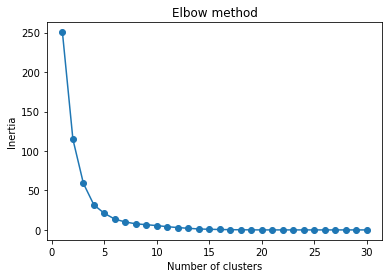


For  FileUtils.writeStringToFile


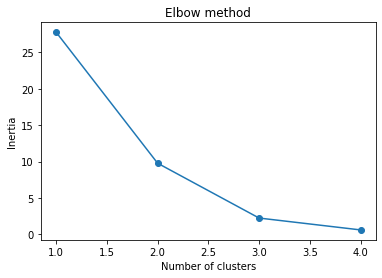


For  Graphics2D.fill


/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_clusters (30). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_clusters (31). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_clusters (32). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_clusters (33). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_

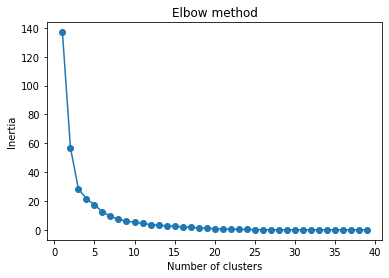


For  IOUtils.toString


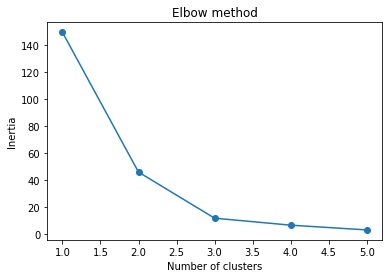


For  PrinterJob.pageDialog


/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_clusters (30). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_clusters (31). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_clusters (32). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_clusters (33). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (29) found smaller than n_

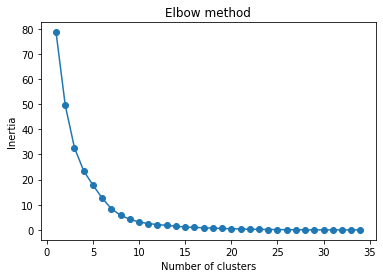


For  Properties.loadFromXML


/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (22) found smaller than n_clusters (23). Possibly due to duplicate points in X.



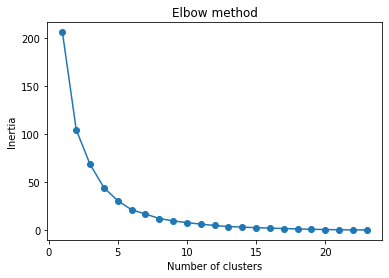


For  Servant._poa


/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters

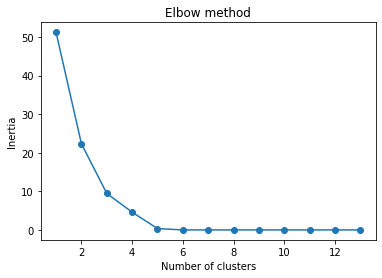


For  Window.pack


/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ConvergenceWarning:

Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.



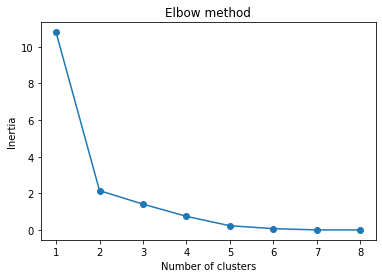

In [ ]:
for api in gnn_labels_for_manual_data.keys():
    embeddings_as_list, file_names = [], []
    for file_name in gnn_labels_for_manual_data[api].keys():
        embeddings_as_list.append(manual_data_embeddings[file_name])
        file_names.append(file_name)
        
    print("\nFor ", api)
    
    elbow_for_kmeans(embeddings_as_list)

In [ ]:
KMeans_cluster_numbers = {"Driver.connect" : 5, "FileUtils.writeStringToFile" : 2, 
                          "Graphics2D.fill" : 5, "IOUtils.toString" : 2, 
                          "PrinterJob.pageDialog" : 8, "Properties.loadFromXML" : 6, 
                          "Servant._poa" : 4, "Window.pack" : 3}

for api in gnn_labels_for_manual_data.keys():
    embeddings_as_list, file_names = [], []
    for file_name in gnn_labels_for_manual_data[api].keys():
        embeddings_as_list.append(manual_data_embeddings[file_name])
        file_names.append(file_name)
        
    kmeans_model = KMeans(n_clusters = KMeans_cluster_numbers[api])
    clusters_kmeans = kmeans_model.fit_predict(embeddings_as_list)
    print("\nNumber of clusters for {} is {} having total {} datapoints".format(api, len(set(clusters_kmeans)), len(embeddings_as_list)))

    for file_name, cluster_no in zip(file_names, clusters_kmeans):
        gnn_labels_for_manual_data[api][file_name] = cluster_no


Number of clusters for Driver.connect is 5 having total 31 datapoints

Number of clusters for FileUtils.writeStringToFile is 2 having total 5 datapoints

Number of clusters for Graphics2D.fill is 5 having total 40 datapoints

Number of clusters for IOUtils.toString is 2 having total 6 datapoints

Number of clusters for PrinterJob.pageDialog is 8 having total 35 datapoints

Number of clusters for Properties.loadFromXML is 6 having total 24 datapoints

Number of clusters for Servant._poa is 4 having total 14 datapoints

Number of clusters for Window.pack is 3 having total 9 datapoints


### Pair-wise classification labels

In [13]:
gt_classification_labels, ck_classification_labels, gnn_classification_labels = {}, {}, {}

for api in APIs:
    gt_classification_labels[api] = do_classification_from_clustering(gt_labels_for_manual_data[api])
    ck_classification_labels[api] = do_classification_from_clustering(ck_labels_for_manual_data[api])
    gnn_classification_labels[api] = do_classification_from_clustering(gnn_labels_for_manual_data[api])
    
    print("\n", len(gt_labels_for_manual_data[api]), len(gt_classification_labels[api]), 
          len(ck_labels_for_manual_data[api]), len(ck_classification_labels[api]),
          len(gnn_labels_for_manual_data[api]), len(gnn_classification_labels[api]))



 31 465 31 465 31 465

 5 10 5 10 5 10

 4 6 4 6 4 6

 10 45 10 45 10 45

 40 780 40 780 40 780

 8 28 8 28 8 28

 17 136 17 136 17 136

 35 595 35 595 35 595

 24 276 24 276 24 276

 14 91 14 91 14 91

 9 36 9 36 9 36


### Classification accuracy for Code-Kernel

In [14]:
for api in APIs:
    
    ck_classification_labels_as_list, gt_classification_labels_as_list = [], []
    
    for pair in gt_classification_labels[api]:
        gt_classification_labels_as_list.append(gt_classification_labels[api][pair])
        ck_classification_labels_as_list.append(ck_classification_labels[api][pair])
    
    Confusion_matrix = confusion_matrix(gt_classification_labels_as_list, ck_classification_labels_as_list)
    accuracy = "{:.2f}".format(accuracy_score(gt_classification_labels_as_list, ck_classification_labels_as_list) * 100)
    precision = "{:.2f}".format(precision_score(gt_classification_labels_as_list, ck_classification_labels_as_list) * 100)
    recall = "{:.2f}".format(recall_score(gt_classification_labels_as_list, ck_classification_labels_as_list) * 100)
    F1_score = "{:.2f}".format(f1_score(gt_classification_labels_as_list, ck_classification_labels_as_list) * 100)
    
    print("====Accuracy for API: ", api)
    print("Accuracy: {}, precision: {}, recall: {} and f1-score: {}".format(accuracy, precision, recall, F1_score))
    # if api == "IOUtils.toString":
    #     print(gt_classification_labels_as_list, ck_classification_labels_as_list)

====Accuracy for API:  Driver.connect
Accuracy: 98.28, precision: 90.70, recall: 100.00 and f1-score: 95.12
====Accuracy for API:  FilenameUtils.normalize
Accuracy: 40.00, precision: 50.00, recall: 50.00 and f1-score: 50.00
====Accuracy for API:  FileUtils.forceMkdir
Accuracy: 50.00, precision: 50.00, recall: 100.00 and f1-score: 66.67
====Accuracy for API:  FileUtils.writeStringToFile
Accuracy: 68.89, precision: 58.33, recall: 43.75 and f1-score: 50.00
====Accuracy for API:  Graphics2D.fill
Accuracy: 90.77, precision: 71.25, recall: 53.77 and f1-score: 61.29
====Accuracy for API:  IOUtils.toByteArray
Accuracy: 92.86, precision: 100.00, recall: 66.67 and f1-score: 80.00
====Accuracy for API:  IOUtils.toString
Accuracy: 79.41, precision: 16.67, recall: 18.75 and f1-score: 17.65
====Accuracy for API:  PrinterJob.pageDialog
Accuracy: 94.29, precision: 76.34, recall: 97.09 and f1-score: 85.47
====Accuracy for API:  Properties.loadFromXML
Accuracy: 98.19, precision: 100.00, recall: 79.17 an

### Classification accuracy for GNN model

In [15]:
for api in APIs:
    
    gt_classification_labels_as_list, gnn_classification_labels_as_list = [], []
    for pair in gt_classification_labels[api]:
        gt_classification_labels_as_list.append(gt_classification_labels[api][pair])
        gnn_classification_labels_as_list.append(gnn_classification_labels[api][pair])
        
    Confusion_matrix = confusion_matrix(gt_classification_labels_as_list, gnn_classification_labels_as_list)
    accuracy = "{:.2f}".format(accuracy_score(gt_classification_labels_as_list, gnn_classification_labels_as_list) * 100)
    precision = "{:.2f}".format(precision_score(gt_classification_labels_as_list, gnn_classification_labels_as_list) * 100)
    recall = "{:.2f}".format(recall_score(gt_classification_labels_as_list, gnn_classification_labels_as_list) * 100)
    F1_score = "{:.2f}".format(f1_score(gt_classification_labels_as_list, gnn_classification_labels_as_list) * 100)
    
    print("====Accuracy for API: ", api)
    print("Accuracy: {}, precision: {}, recall: {} and f1-score: {}".format(accuracy, precision, recall, F1_score))
    
    # if api == "FileUtils.writeStringToFile":
    #     print(gt_classification_labels_as_list, gnn_classification_labels_as_list)

====Accuracy for API:  Driver.connect
Accuracy: 76.56, precision: 32.97, recall: 38.46 and f1-score: 35.50
====Accuracy for API:  FilenameUtils.normalize
Accuracy: 40.00, precision: 50.00, recall: 33.33 and f1-score: 40.00
====Accuracy for API:  FileUtils.forceMkdir
Accuracy: 100.00, precision: 100.00, recall: 100.00 and f1-score: 100.00
====Accuracy for API:  FileUtils.writeStringToFile
Accuracy: 51.11, precision: 20.00, recall: 12.50 and f1-score: 15.38
====Accuracy for API:  Graphics2D.fill
Accuracy: 73.72, precision: 23.24, recall: 40.57 and f1-score: 29.55
====Accuracy for API:  IOUtils.toByteArray
Accuracy: 75.00, precision: 40.00, recall: 33.33 and f1-score: 36.36
====Accuracy for API:  IOUtils.toString
Accuracy: 62.50, precision: 14.29, recall: 43.75 and f1-score: 21.54
====Accuracy for API:  PrinterJob.pageDialog
Accuracy: 60.34, precision: 22.86, recall: 54.37 and f1-score: 32.18
====Accuracy for API:  Properties.loadFromXML
Accuracy: 86.59, precision: 25.93, recall: 29.17 an

In [ ]:
for api in gt_labels_for_manual_data.keys():
    if api != "Driver.connect":
        continue
    #print(gt_labels_for_manual_data[api])
    clusters = {}
    for api_example in gt_labels_for_manual_data[api].keys():
        if gt_labels_for_manual_data[api][api_example] in clusters:
            clusters[gt_labels_for_manual_data[api][api_example]].append(api_example)
        else:
            clusters[gt_labels_for_manual_data[api][api_example]] = [api_example]
    print(clusters)

{2: ['A_connect_092_MockDatabaseDriverTest_1_1_2_sample-2_Driver.connect_graph_dump.txt', 'M_connect_092_MockDatabaseDriverTest_1_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_132_ConnectionManager_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_029_ConnectionProfile_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_131_ConnectionManager_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_114_SQLGet_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_134_JdbcManager_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_092_MockDatabaseDriverTest_1_0_2_sample-2_Driver.connect_graph_dump.txt'], 0: ['M_connect_131_ConnectionManager_0_0_sample-0_Driver.connect_graph_dump.txt', 'M_connect_132_ConnectionManager_0_0_sample-0_Driver.connect_graph_dump.txt', 'M_connect_114_SQLGet_0_0_sample-0_Driver.connect_graph_dump.txt'], 9: ['A_connect_030_JPDriver_0_0_9_sample-9_Driver.connect_graph_dump.txt'], 4: ['M_connect_014_DriverShim_0_4_sample-4_Driver.conn

In [ ]:
for api in gnn_labels_for_manual_data.keys():
    if api != "Driver.connect":
        continue
    #print(gt_labels_for_manual_data[api])
    clusters = {}
    for api_example in gnn_labels_for_manual_data[api].keys():
        if gnn_labels_for_manual_data[api][api_example] in clusters:
            clusters[gnn_labels_for_manual_data[api][api_example]].append(api_example)
        else:
            clusters[gnn_labels_for_manual_data[api][api_example]] = [api_example]
    print(clusters)

{0: ['A_connect_092_MockDatabaseDriverTest_1_1_2_sample-2_Driver.connect_graph_dump.txt', 'M_connect_092_MockDatabaseDriverTest_1_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_132_ConnectionManager_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_025_ConnectionFactoryImpl_0_0_13_sample-13_Driver.connect_graph_dump.txt', 'A_connect_131_ConnectionManager_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_092_MockDatabaseDriverTest_1_0_2_sample-2_Driver.connect_graph_dump.txt'], 1: ['M_connect_131_ConnectionManager_0_0_sample-0_Driver.connect_graph_dump.txt', 'A_connect_029_ConnectionProfile_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'M_connect_025_ConnectionFactoryImpl_0_10_sample-10_Driver.connect_graph_dump.txt', 'M_connect_134_JdbcManager_0_14_sample-14_Driver.connect_graph_dump.txt', 'M_connect_132_ConnectionManager_0_0_sample-0_Driver.connect_graph_dump.txt', 'M_connect_114_SQLGet_0_0_sample-0_Driver.connect_graph_dump.txt', 'A_connect_114_SQLGet_0_0_2_sa

In [ ]:
for api in gnn_labels_for_manual_data.keys():
    if api != "Driver.connect":
        continue
    #print(gt_labels_for_manual_data[api])
    clusters = {}
    for api_example in gnn_labels_for_manual_data[api].keys():
        if "sample-2_" in api_example:
            if gnn_labels_for_manual_data[api][api_example] in clusters:
                clusters[gnn_labels_for_manual_data[api][api_example]].append(api_example)
            else:
                clusters[gnn_labels_for_manual_data[api][api_example]] = [api_example]
    print(clusters)

{0: ['A_connect_092_MockDatabaseDriverTest_1_1_2_sample-2_Driver.connect_graph_dump.txt', 'M_connect_092_MockDatabaseDriverTest_1_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_132_ConnectionManager_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_131_ConnectionManager_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_092_MockDatabaseDriverTest_1_0_2_sample-2_Driver.connect_graph_dump.txt'], 1: ['A_connect_029_ConnectionProfile_0_0_2_sample-2_Driver.connect_graph_dump.txt', 'A_connect_114_SQLGet_0_0_2_sample-2_Driver.connect_graph_dump.txt'], 6: ['A_connect_134_JdbcManager_0_0_2_sample-2_Driver.connect_graph_dump.txt']}


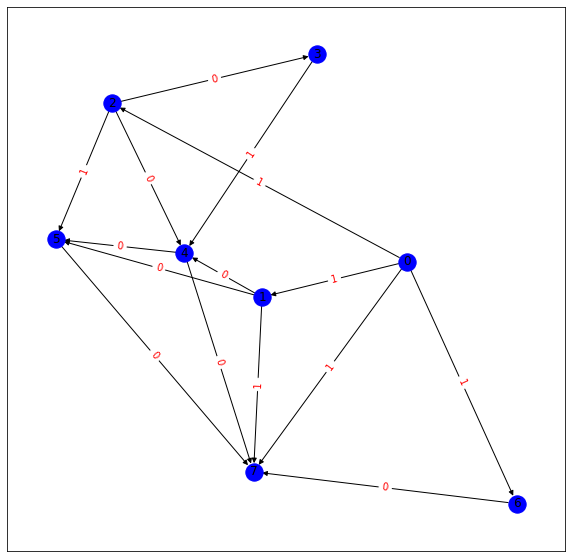

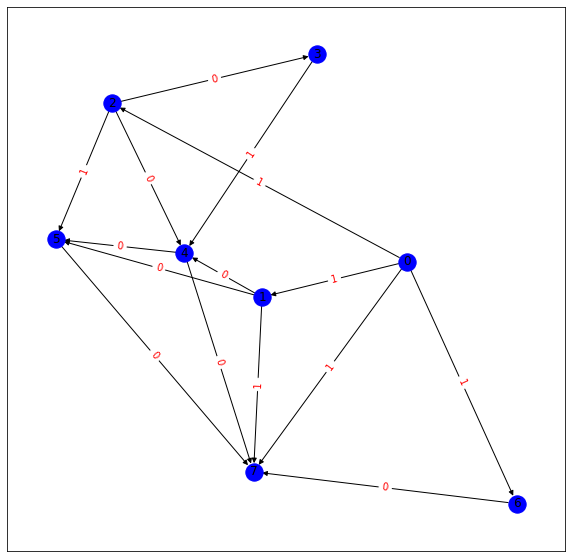

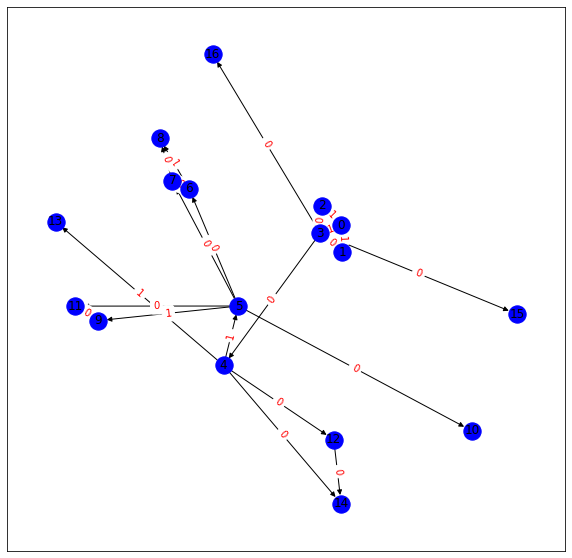

In [ ]:
api_examples = ['M_connect_131_ConnectionManager_0_0_sample-0_Driver.connect_graph_dump.txt', 'M_connect_132_ConnectionManager_0_0_sample-0_Driver.connect_graph_dump.txt', 'M_connect_114_SQLGet_0_0_sample-0_Driver.connect_graph_dump.txt']
for data in manual_dataset:
    if data.api in api_examples:
        visualize_graph(data, color="blue")